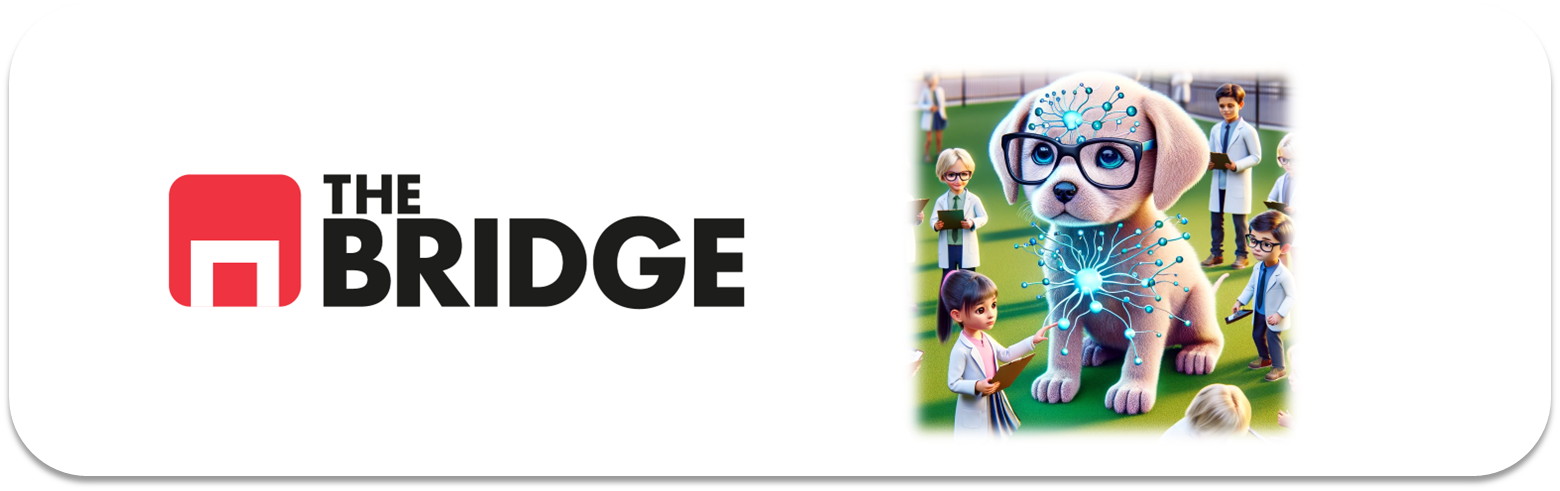

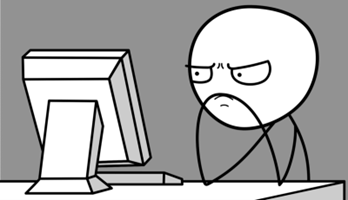

Para ejercitarte y afianzar lo aprendido sobre **Redes Recurrentes y series temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import pandas as pd
import numpy as np

### Problema a resolver

El ayuntamiento de New City está preocupado por el nivel de contaminación de aire y quiere poner en marcha un sistema de prevención del uso de determinado tipo de vehículos y maquinaria pesada en aquellos días en los que la contaminación sea muy alta, en concreto queremos anticiparnos en periodos de 6 horas. Como primer paso para la implantación de la medida, decide crear un modelo de predicción de contaminación de forma que pueda emplearlo para enviar alertas o avisos de posible de prohibición con la suficiente anticipación que permita a los ciudadanos y trabajadores organizarse mejor. 

Para ello nos ha suministrado una serie de datos de contaminación del aire en cinco años dependiente de una serie de features que son medibles día a día y nos pide crear dicho modelo. Como somos unos "pioneros" vamos a hacerlo empleando lo aprendido con redes recurrentes.

A través de los siguientes ejercicios vamos a crear un modelo de regresión que permita estimar dicha polución en los periodos estimados. Aquí tienes un breve descripción de las columnas:

- **No**: número de fila
- **year**: año de los datos en esta fila
- **month**: mes de los datos en esta fila
- **day**: día de los datos en esta fila
- **hour**: hora de los datos en esta fila
- **pm2.5**: concentración de PM2.5
- **DEWP**: Punto de rocío
- **TEMP**: Temperatura
- **PRES**: Presión
- **cbwd**: Dirección combinada del viento
- **Iws**: Velocidad acumulada del viento
- **Is**: Horas acumuladas de nieve
- **Ir**: Horas acumuladas de lluvia


### Ejercicio 1: Visión preliminar

Carga el dataset. Echa un vistazo (no pintes series todavía) y decide cuál debe ser el target.

In [5]:
df= pd.read_csv('./data/air_pollution_new_city.csv',sep='|')
df.head(5)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2019,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2019,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2019,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2019,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2019,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43800 non-null  int64  
 1   year    43800 non-null  int64  
 2   month   43800 non-null  int64  
 3   day     43800 non-null  int64  
 4   hour    43800 non-null  int64  
 5   pm2.5   43800 non-null  float64
 6   DEWP    43800 non-null  int64  
 7   TEMP    43800 non-null  float64
 8   PRES    43800 non-null  float64
 9   cbwd    43800 non-null  object 
 10  Iws     43800 non-null  float64
 11  Is      43800 non-null  int64  
 12  Ir      43800 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


### Ejercicio 2: Preparación del dataset

Como todo dataset con series temporales, si tenemos las fechas, es conveniente convertirla a datatime y luego hacerlo el indice de nuestro dataset. Hazlo sobre un dataframe df_indexed copia del original. Deshazte de las columnas que no sean informativas y cambia el nombre de las columnas para que sean más "expresivas".

In [8]:
# Crear una copia del dataframe
df_indexed = df.copy()

# Convertir a datetime
df_indexed["datetime"] = pd.to_datetime(df_indexed[["year", "month", "day", "hour"]])

# Establecer la nueva columna como índice
df_indexed.set_index("datetime", inplace=True)

# Eliminar columnas innecesarias
df_indexed.drop(columns=["No", "year", "month", "day", "hour"], inplace=True)

# Renombrar columnas para mayor claridad
df_indexed.rename(columns={
    "pm2.5": "PM2.5_Concentration",
    "DEWP": "Dew_Point",
    "TEMP": "Temperature",
    "PRES": "Pressure",
    "cbwd": "Wind_Direction",
    "Iws": "Wind_Speed",
    "Is": "Snow_Hours",
    "Ir": "Rain_Hours"
}, inplace=True)

# Mostrar las primeras filas del dataframe procesado
df_indexed.head()


,PM2.5_Concentration,Dew_Point,Temperature,Pressure,Wind_Direction,Wind_Speed,Snow_Hours,Rain_Hours
datetime,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### Ejercicio 3: Split y MiniEda_I

Antes de continuar es hora analizar visualmente las series, pero para hacerlo formalmente correcto, analiza sólo de 2019 a 2022 (2023 será nuestro periodo de validaciones y test). Crea una gráfica com el target para el periodo de train. Descompón la serie de forma aditiva y analiza visualmente si existe estacionalidad, tendencia y si podríamos decir si es estacionaria o no

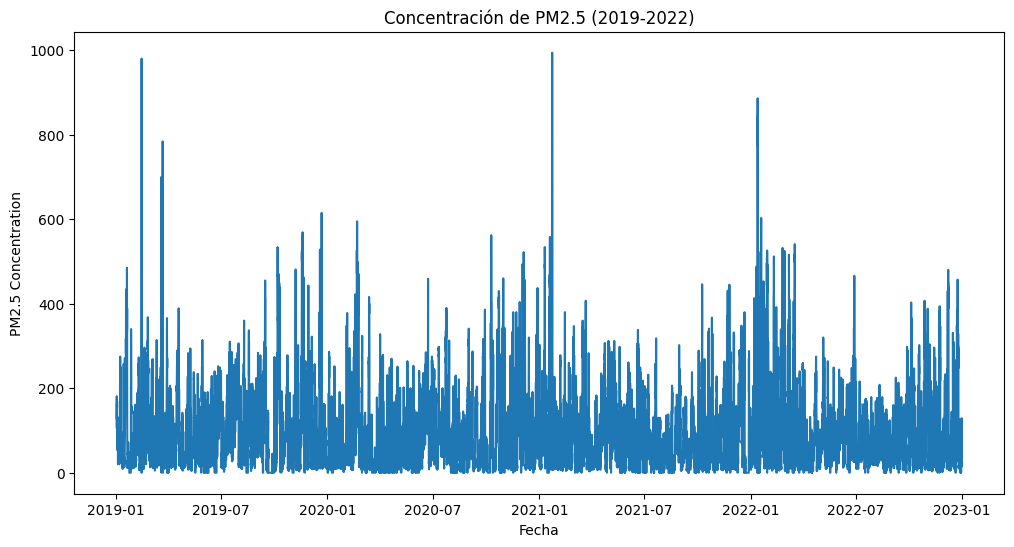

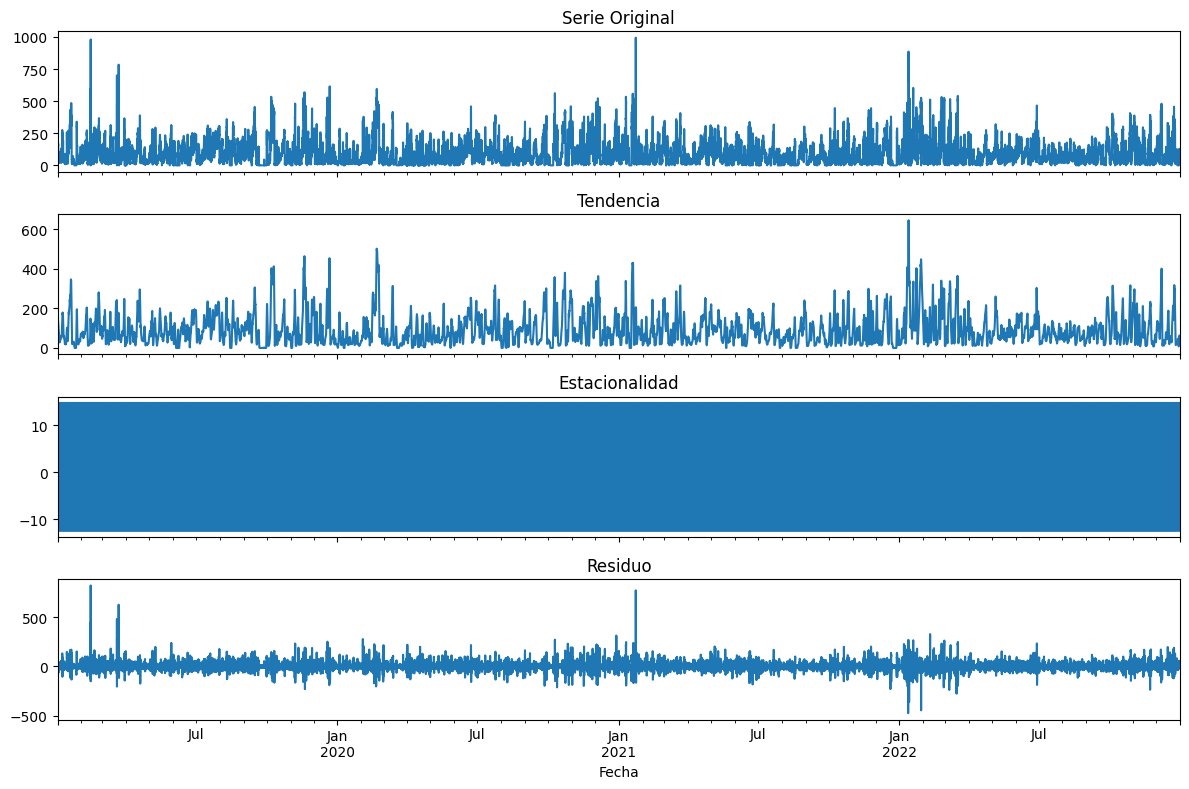

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Ordenar el índice datetime
df_indexed = df_indexed.sort_index()

# Filtrar datos de entrenamiento (2019-2022)
df_train = df_indexed.loc["2019-01-01":"2022-12-31"]

# Graficar la serie temporal de PM2.5
plt.figure(figsize=(12,6))
sns.lineplot(data=df_train, x=df_train.index, y="PM2.5_Concentration")
plt.title("Concentración de PM2.5 (2019-2022)")
plt.xlabel("Fecha")
plt.ylabel("PM2.5 Concentration")
plt.show()

# Descomposición aditiva de la serie temporal
decomposition = seasonal_decompose(df_train["PM2.5_Concentration"], model='additive', period=24)

# Graficar la descomposición
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
decomposition.observed.plot(ax=axes[0], title='Serie Original')
decomposition.trend.plot(ax=axes[1], title='Tendencia')
decomposition.seasonal.plot(ax=axes[2], title='Estacionalidad')
decomposition.resid.plot(ax=axes[3], title='Residuo')
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()



### Ejercicio 4: MiniEDA (II)

Para completar el minieda, crea una figura con tantos subplots como series temporales y en cada subplot muestra una de las series para el train. Empieza por el target y haz un pequeño análisis visual. Por supuesto, emplea sólo el train

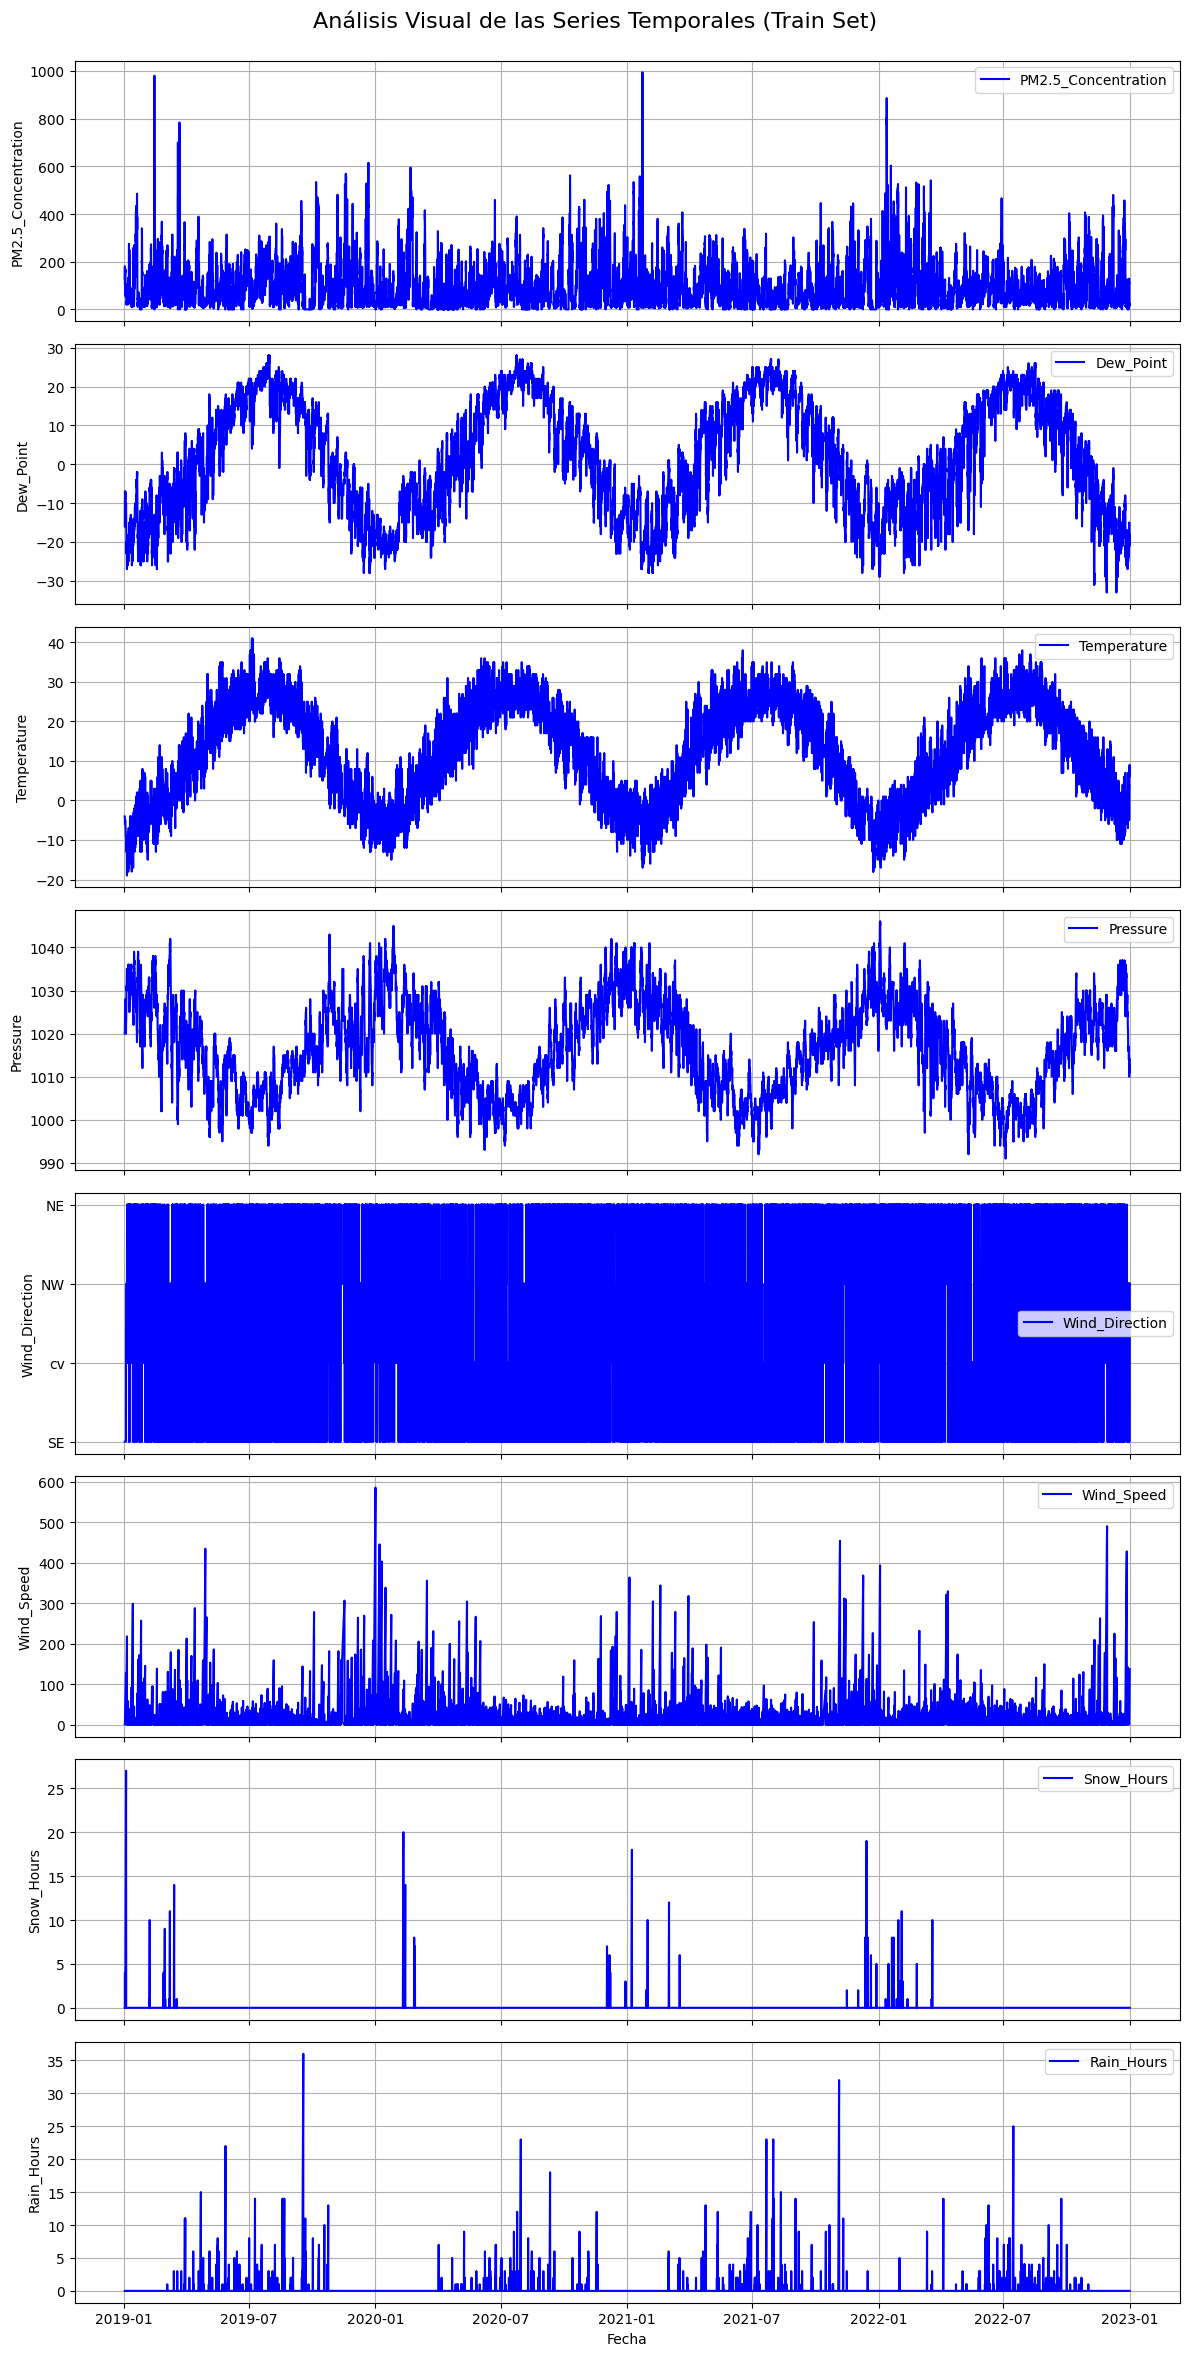

In [ ]:
# Definir las columnas a graficar
features = df_train.columns.tolist()

# Crear la figura con subgráficos
fig, axes = plt.subplots(len(features), 1, figsize=(12, 3 * len(features)), sharex=True)
fig.suptitle("Análisis Visual de las Series Temporales (Train Set)", fontsize=16)

# Graficar cada serie en su subplot correspondiente
for i, col in enumerate(features):
    axes[i].plot(df_train.index, df_train[col], label=col, color='b')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid()

plt.xlabel("Fecha")
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Ajustar el diseño
plt.show()


### Ejercicio 5

Vamos a preparar el dataset. En principio vamos a predecir el valor de las siguientes 12 horas a partir de las 48 horas anteriores. Es decir hay que ajustar el dataset para que genere batches de 32 secuencias de 48 instancias y con un target que es una secuencia de los 12 periodos siguientes. Primero codifica la dirección del viento con un one-hot encoding sobre el df_indexed. Convierte todos los valores a np.float32 al final: 

In [12]:
from sklearn.preprocessing import OneHotEncoder

# Aplicar One-Hot Encoding a la dirección del viento
encoder = OneHotEncoder(sparse_output=False, drop='first')
wind_direction_encoded = encoder.fit_transform(df_indexed[['Wind_Direction']])
wind_direction_columns = encoder.get_feature_names_out(['Wind_Direction'])

df_encoded = df_indexed.drop(columns=['Wind_Direction'])  # Eliminar la columna original
df_encoded[wind_direction_columns] = wind_direction_encoded  # Agregar nuevas columnas

# Convertir a float32
df_encoded = df_encoded.astype(np.float32)

# Mostrar las primeras filas del dataset procesado
df_encoded.head()


,PM2.5_Concentration,Dew_Point,Temperature,Pressure,Wind_Speed,Snow_Hours,Rain_Hours,Wind_Direction_NW,Wind_Direction_SE,Wind_Direction_cv
datetime,,,,,,,,,,
2019-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,1.79,0.0,0.0,0.0,1.0,0.0
2019-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.68,0.0,0.0,0.0,1.0,0.0
2019-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,3.57,0.0,0.0,0.0,1.0,0.0
2019-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,5.36,1.0,0.0,0.0,1.0,0.0
2019-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,6.25,2.0,0.0,0.0,1.0,0.0


### Ejercicio 6

Ahora crea los datasets de train, validación y test. El primero para que tenga el periodo 2020 septiembre de 2023, el segundo para octubre de 2023 y el tercero para noviembre de 2023. Ojo ten en cuenta que vamos a necesitar tanto los valores anteriores como posteriores en los periodos (48 horas antes y 12 horas después). Escálalos (importante, escala el target por separado para poder hacer la inversión en el momento de evaluar)

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Definir los periodos
train_start, train_end = "2020-01-01", "2023-09-30"
val_start, val_end = "2023-10-01", "2023-10-31"
test_start, test_end = "2023-11-01", "2023-11-30"

# Filtrar los datos con margen de 48 horas antes y 12 horas después
df_train = df_encoded.loc[train_start:train_end]
df_val = df_encoded.loc[val_start:val_end]
df_test = df_encoded.loc[test_start:test_end]

# Escaladores
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Escalar features (excepto PM2.5, que es el target)
df_train_scaled = df_train.copy()
df_val_scaled = df_val.copy()
df_test_scaled = df_test.copy()

features = df_encoded.columns[df_encoded.columns != "PM2.5_Concentration"]
df_train_scaled[features] = scaler_features.fit_transform(df_train[features])
df_val_scaled[features] = scaler_features.transform(df_val[features])
df_test_scaled[features] = scaler_features.transform(df_test[features])

# Escalar target por separado
df_train_scaled[["PM2.5_Concentration"]] = scaler_target.fit_transform(df_train[["PM2.5_Concentration"]])
df_val_scaled[["PM2.5_Concentration"]] = scaler_target.transform(df_val[["PM2.5_Concentration"]])
df_test_scaled[["PM2.5_Concentration"]] = scaler_target.transform(df_test[["PM2.5_Concentration"]])

# Mostrar información de los datasets
print("Train Set Shape:", df_train_scaled.shape)
print("Validation Set Shape:", df_val_scaled.shape)
print("Test Set Shape:", df_test_scaled.shape)


Train Set Shape: (32856, 10)
Validation Set Shape: (744, 10)
Test Set Shape: (720, 10)


### Ejercicio 8

Crea un modelo con una capa de celdas sencillas recurrentes con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Definir funciones para crear secuencias
def create_sequences(data, seq_length=48, target_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length - target_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length : i + seq_length + target_length, 0])  # Target es PM2.5
    return np.array(X), np.array(y)

# Crear secuencias para train, val y test
seq_length, target_length = 48, 12
X_train, y_train = create_sequences(df_train_scaled.values, seq_length, target_length)
X_val, y_val = create_sequences(df_val_scaled.values, seq_length, target_length)
X_test, y_test = create_sequences(df_test_scaled.values, seq_length, target_length)

# Construcción del modelo
model = Sequential([
    SimpleRNN(32, activation='relu', return_sequences=False, input_shape=(seq_length, X_train.shape[2])),
    Dense(target_length)
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluar el modelo
y_pred_scaled = model.predict(X_test)

# Invertir la escala de los valores predichos y reales
y_test_original = scaler_target.inverse_transform(y_test)
y_pred_original = scaler_target.inverse_transform(y_pred_scaled)

# Calcular métricas en unidades originales
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1025/1025 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0285 - mae: 0.1034 - val_loss: 0.0062 - val_mae: 0.0563
Epoch 2/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0038 - mae: 0.0422 - val_loss: 0.0058 - val_mae: 0.0520
Epoch 3/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0035 - mae: 0.0393 - val_loss: 0.0056 - val_mae: 0.0509
Epoch 4/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0036 - mae: 0.0392 - val_loss: 0.0051 - val_mae: 0.0490
Epoch 5/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0034 - mae: 0.0378 - val_loss: 0.0052 - val_mae: 0.0487
Epoch 6/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0034 - mae: 0.0376 - val_loss: 0.0050 - val_mae: 0.0474
Epoch 7/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0034 - mae: 0.0375 - val_loss: 0.0052 - val_mae: 0.0483
Epoch 8/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0034 - mae: 0.0373 - val_loss: 0.0055 - val_mae: 0.0501
Epoch 9/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

### Ejercicio 9

Crea un modelo con una capa de celdas LSTM con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [15]:
from tensorflow.keras.layers import LSTM

# Construcción del modelo con LSTM
model_lstm = Sequential([
    LSTM(32, activation='relu', return_sequences=False, input_shape=(seq_length, X_train.shape[2])),
    Dense(target_length)
])

# Compilar el modelo
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Entrenar el modelo
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluar el modelo
y_pred_scaled_lstm = model_lstm.predict(X_test)

# Invertir la escala de los valores predichos y reales
y_test_original = scaler_target.inverse_transform(y_test)
y_pred_original_lstm = scaler_target.inverse_transform(y_pred_scaled_lstm)

# Calcular métricas en unidades originales
rmse_lstm = np.sqrt(mean_squared_error(y_test_original, y_pred_original_lstm))
mae_lstm = mean_absolute_error(y_test_original, y_pred_original_lstm)

print(f"RMSE LSTM: {rmse_lstm:.2f}")
print(f"MAE LSTM: {mae_lstm:.2f}")


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1025/1025 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0083 - mae: 0.0612 - val_loss: 0.0057 - val_mae: 0.0520
Epoch 2/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0037 - mae: 0.0406 - val_loss: 0.0051 - val_mae: 0.0483
Epoch 3/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0034 - mae: 0.0384 - val_loss: 0.0046 - val_mae: 0.0451
Epoch 4/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0032 - mae: 0.0370 - val_loss: 0.0047 - val_mae: 0.0463
Epoch 5/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0033 - mae: 0.0369 - val_loss: 0.0049 - val_mae: 0.0458
Epoch 6/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0031 - mae: 0.0359 - val_loss: 0.0044 - val_mae: 0.0440
Epoch 7/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0032 - mae: 0.0360 - val_loss: 0.0048 - val_mae: 0.0455
Epoch 8/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0030 - mae: 0.0353 - val_loss: 0.0049 - val_mae: 0.0460
Epoch 9/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/st

### Ejercicio 10

Crea un modelo con una capa de celdas GRU con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [16]:
from tensorflow.keras.layers import GRU

# Construcción del modelo con GRU
model_gru = Sequential([
    GRU(32, activation='relu', return_sequences=False, input_shape=(seq_length, X_train.shape[2])),
    Dense(target_length)
])

# Compilar el modelo
model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Entrenar el modelo
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluar el modelo directamente
loss_gru, mae_gru = model_gru.evaluate(X_test, y_test, verbose=0)

# Hacer predicciones
y_pred_scaled_gru = model_gru.predict(X_test)

# Invertir la escala de los valores predichos y reales
y_test_original = scaler_target.inverse_transform(y_test)
y_pred_original_gru = scaler_target.inverse_transform(y_pred_scaled_gru)

# Calcular métricas en unidades originales
rmse_gru = np.sqrt(mean_squared_error(y_test_original, y_pred_original_gru))
mae_gru = mean_absolute_error(y_test_original, y_pred_original_gru)

print(f"RMSE GRU: {rmse_gru:.2f}")
print(f"MAE GRU: {mae_gru:.2f}")


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1025/1025 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0070 - mae: 0.0565 - val_loss: 0.0055 - val_mae: 0.0507
Epoch 2/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0034 - mae: 0.0386 - val_loss: 0.0051 - val_mae: 0.0481
Epoch 3/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0034 - mae: 0.0377 - val_loss: 0.0049 - val_mae: 0.0471
Epoch 4/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0032 - mae: 0.0370 - val_loss: 0.0049 - val_mae: 0.0466
Epoch 5/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0032 - mae: 0.0368 - val_loss: 0.0046 - val_mae: 0.0450
Epoch 6/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0032 - mae: 0.0363 - val_loss: 0.0048 - val_mae: 0.0456
Epoch 7/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0032 - mae: 0.0364 - val_loss: 0.0056 - val_mae: 0.0490
Epoch 8/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0030 - mae: 0.0356 - val_loss: 0.0050 - val_mae: 0.0477
Epoch 9/20
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/st